# PEFT-Lora on Quantized 8-bit DistilBert

## Introduction

This notebook demonstrates how to fine-tune a quantized 8-bit version of the DistilBert model using **Parameter-Efficient Fine-Tuning (PEFT)** with Low-Rank Adaptation (LoRA). Fine-tuning large pre-trained models is a common task in natural language processing (NLP), but it is often computationally expensive and resource-intensive, especially when dealing with models in their full precision (i.e., 32-bit floating point). By leveraging quantization and PEFT, we can significantly reduce the model's memory footprint and computational requirements, enabling efficient fine-tuning with fewer parameters and in reduced precision.

The DistilBert model used in this notebook has been previously quantized to 8-bit, allowing for faster and more resource-efficient computations. To further improve the model's performance without drastically increasing its size or complexity, we will apply **LoRA**, a technique that reduces the number of trainable parameters by injecting learnable low-rank matrices into the attention heads of the transformer. This method maintains the performance of full fine-tuning while being much more efficient.

## Notebook Overview

In this notebook, we will:

1. Load the pre-quantized 8-bit version of DistilBert.
2. Apply LoRA to introduce parameter-efficient fine-tuning.
3. Run the fine-tuning process while optimizing memory usage and computational performance.
4. Evaluate the model's performance using metrics such as accuracy and observe the improvements gained from fine-tuning.

### Why PEFT and LoRA?

**PEFT** techniques, such as LoRA, are increasingly important as models grow larger and more complex. Traditional fine-tuning modifies all of a model’s parameters, which can be prohibitively expensive. In contrast, PEFT modifies only a small subset of parameters, resulting in significantly reduced memory requirements and faster training. **LoRA** achieves this by decomposing the weight updates into low-rank matrices, allowing the model to efficiently learn task-specific adaptations without the overhead of training the entire model. A very good introduction about this topic can be read from the following blog - [heidloff/lora](https://heidloff.net/article/efficient-fine-tuning-lora/)

![lora](./assets/lora.png)

<small><i>Source: https://heidloff.net/article/efficient-fine-tuning-lora/</i></source>

By combining **quantization** and **LoRA**, this notebook showcases how to fine-tune large models on resource-constrained environments like personal laptops or smaller cloud instances, without sacrificing significant performance.

This implementation draws inspiration from various sources, including the work shared by the Kaggle community. Special thanks to [kaggle/anthonynam](https://www.kaggle.com/code/anthonynam/qlora-fine-tuning-with-distilbert-daigt-v2/script)'s work for providing valuable insights and inspiration for this notebook.

---

This notebook serves as an efficient, practical guide to fine-tuning quantized models using PEFT techniques, making it ideal for users who want to maximize the performance of their models without heavy computational costs.

### Import libraries

In [1]:
# Import libraries
import torch
from torch.utils.data import DataLoader, Dataset

from transformers import (
    AutoModelForSequenceClassification as DistilBertForSequenceClassification, 
    DistilBertTokenizer, BitsAndBytesConfig,
    TrainingArguments, AdamW,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding, Trainer
)
from datasets import load_dataset
from peft import (
    PeftConfig, LoraConfig,
    TaskType, get_peft_model,
    prepare_model_for_kbit_training
)

import math
from tqdm import tqdm
import numpy as np

/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Original (FP32) Model Stats

Let us load the original model and get its performance stats on the test dataset.

In [3]:
# Load pre-trained model and tokenizer
model_name = 'bhadresh-savani/distilbert-base-uncased-emotion'
model_orig = DistilBertForSequenceClassification.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

model_orig.to(device)
model_orig.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [4]:
# Load the dataset
ds = load_dataset("dair-ai/emotion", "split")

In [5]:
# Helper method to evaluate
def evaluate(model, ds, batch_size=64, device='cuda'):
    model.eval()
    total, correct = 0, 0
    dataloader = DataLoader(ds['test'], batch_size=batch_size)
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            tokenized = tokenizer(batch['text'], truncation=True, padding=True, return_tensors="pt")
            input_ids = tokenized.input_ids.to(device)
            attention_mask = tokenized.attention_mask.to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

# Evaluate the original model
original_accuracy = evaluate(model_orig, ds)
original_memory = model_orig.get_memory_footprint() / (1024 * 1024) # MB
print(f'\nOriginal model accuracy: {original_accuracy * 100:.2f}%')
print(f"Original model memory footprint: {original_memory} MB")

Evaluating: 100%|███████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.80it/s]


Original model accuracy: 92.70%
Original model memory footprint: 255.4287338256836 MB


### Quantized 8-bit Model Stats

Now let's load the model in quantized 8-bit format and get its statistics

In [6]:
# Load the 8-bit model and evaluate
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model_8bit = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config
)

model_8bit.eval()

`low_cpu_mem_usage` was None, now set to True since model is quantized.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (k_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (v_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (out_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout

In [7]:
accuracy_8bit = evaluate(model_8bit, ds)
memory_8bit = model_8bit.get_memory_footprint() / (1024 * 1024) # MB

print(f'\n8 bit model accuracy: {accuracy_8bit * 100:.2f}%')
print(f'8 bit model memory footprint: {memory_8bit} MB')

Evaluating: 100%|███████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.59it/s]


8 bit model accuracy: 28.40%
8 bit model memory footprint: 86.6538200378418 MB


### Model Comparison: Accuracy vs Memory Footprint

When we compare the performance and memory usage of the quantized 8-bit DistilBert model versus the original full-precision model. While quantization significantly reduces the memory footprint, it results in a noticeable degradation in model accuracy.

| **Model**             | **Accuracy (%)** | **Memory Footprint (MB)** |
|-----------------------|------------------|---------------------------|
| 8-bit DistilBert       | 28.40            | 86.65                     |
| Original DistilBert    | 92.70            | 255.43                    |

As seen in the table:
- The **8-bit model** offers a substantial reduction in memory usage, making it suitable for environments with limited resources.
- However, this reduction comes at the cost of a significant drop in **accuracy**.

In the following section, we will attempt to improve the accuracy of the 8-bit model using **Parameter-Efficient Fine-Tuning (PEFT)**, while still maintaining its memory efficiency.

## PEFT - Lora

### Prepare Model and Adapter

In [8]:
# Let us load a new model for LORA training
model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    low_cpu_mem_usage=True
)

In [9]:
# Helper method to print number of trainable parameters
# Source - https://www.kaggle.com/code/anthonynam/qlora-fine-tuning-with-distilbert-daigt-v2
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\n" + \
        f"all model parameters: {all_model_params}\n" + \
        f"percentage of trainable model parameters: " + \
        f"{100 * trainable_model_params / all_model_params:.2f}%"

# Number of trainable parameters
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 23858694
all model parameters: 66958086
percentage of trainable model parameters: 35.63%


In [10]:
# Prepare the model for LORA training
model = prepare_model_for_kbit_training(model)

In [11]:
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=16, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["k_lin","v_lin"], # We will only apply LORA to key/value linear layers.
    bias='none',
    task_type=TaskType.SEQ_CLS # Seqence Classification Task
)

In [12]:
# Get our LoRA-enabled model
model.add_adapter(lora_config)

# Reduced trainble parameters
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 147456
all model parameters: 67105542
percentage of trainable model parameters: 0.22%


**NOTE** - Observe the decrease in trainable parameters from 35.63% to 0.22%!!!

### Prepare Dataset

In [13]:
# Prepare dataset
# Tokenize function
def tokenize_func(data):
    return tokenizer(data['text'], max_length=512, padding='max_length', return_attention_mask=True, truncation=True)

# Tokenize the Training Data
train_dataset = ds['train'].map(tokenize_func, batched=True, remove_columns=["text"])
val_dataset = ds['validation'].map(tokenize_func,batched=True, remove_columns=["text"])

### Training

In [14]:
from sklearn.metrics import accuracy_score
import numpy as np

# Define Eval Metric
def metrics(eval_prediction):
    logits, labels = eval_prediction
    
    # Convert logits to predicted class labels by taking the argmax
    predictions = np.argmax(logits, axis=1)
    
    # Compute accuracy by comparing predictions to true labels
    accuracy = accuracy_score(labels, predictions)
    
    return {"Val-Accuracy": accuracy}

In [15]:
# Source - https://www.kaggle.com/code/anthonynam/qlora-fine-tuning-with-distilbert-daigt-v2
train_batch_size = 32
eval_batch_size = 32

# Define training Args
peft_training_args = TrainingArguments(
    output_dir='./results/distilbert-lora',
    logging_dir='./logs/distilbert-lora',
    learning_rate=1e-4,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size, 
    max_steps=22, # NOTE: The max steps is set to 22 for tutorial purposes.
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=10,
    weight_decay=0.01,
    seed=42,
    fp16=True, # Only use with GPU
    report_to='none'
)

# Define Optimzer
optimizer = AdamW(model.parameters(), 
                  lr=1e-4,
                  no_deprecation_warning=True)

# Define Scheduler
n_epochs = peft_training_args.num_train_epochs
total_steps = n_epochs * math.ceil(len(train_dataset) / train_batch_size / 2)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)

# Data Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer, 
    padding="longest"
)


# Define Trainer
peft_trainer = Trainer(
    model=model,
    args=peft_training_args,
    train_dataset=train_dataset, # Training Data
    eval_dataset=val_dataset, # Evaluation Data
    tokenizer=tokenizer,
    compute_metrics=metrics,
    optimizers=(optimizer,lr_scheduler),
    data_collator=collator
)

print(f"Total Steps: {total_steps}")

# Train the model
peft_trainer.train()

/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs


Total Steps: 750.0


/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instea

Step,Training Loss,Validation Loss,Val-accuracy
10,0.043800,0.151511,0.935500
20,0.045200,0.152392,0.936500


/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instea

TrainOutput(global_step=22, training_loss=0.04416496442122893, metrics={'train_runtime': 359.3745, 'train_samples_per_second': 1.959, 'train_steps_per_second': 0.061, 'total_flos': 93582602403840.0, 'train_loss': 0.04416496442122893, 'epoch': 0.044})

### Evaluation

In [16]:
def prepare_model_for_eval(model, verbose=False):
    """
    Helper method to convert all FP32 layers in quantized model to
    FP16 layers. PEFT-LORA doesn't have an automated way to define
    this during training/evaluation. So we need to perform this
    manually. 
    """
    for name, module in model.named_modules():
        # Iterate over the parameters of the module
        for param_name, param in module.named_parameters(recurse=False):
            # Check if the parameter is in float32
            if param.dtype == torch.float32:
                if verbose:
                    print(f"Converting {name}.{param_name} to float16")
                
                # Convert the parameter to float16
                param.data = param.data.half()
    
                # If the parameter has gradients, convert the gradient type as well
                if param.grad is not None:
                    param.grad.data = param.grad.data.half()
    return model

model_8bit_lora = prepare_model_for_eval(peft_trainer.model)
model_8bit_lora.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (k_lin): lora.Linear8bitLt(
              (base_layer): Linear8bitLt(in_features=768, out_features=768, bias=True)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.05, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=768, out_features=8, bias=False)
              )
             

In [17]:
accuracy_8bit_lora = evaluate(model_8bit_lora, ds)
memory_8bit_lora = model_8bit_lora.get_memory_footprint() / (1024 * 1024) # MB

print(f'\n8 bit + Lora model accuracy: {accuracy_8bit_lora * 100:.2f}%')
print(f'8 bit + Lora model memory footprint: {memory_8bit_lora} MB')

Evaluating:   0%|                                                                    | 0/32 [00:00<?, ?it/s]/home/sri/miniconda3/envs/llmq/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Evaluating: 100%|███████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.00it/s]


8 bit + Lora model accuracy: 92.50%
8 bit + Lora model memory footprint: 87.0068473815918 MB


### Conclusion

From above results, we compare the performance and memory usage of three models: the original full-precision DistilBert, the quantized 8-bit DistilBert, and the 8-bit DistilBert fine-tuned using **Low-Rank Adaptation (LoRA)**. While the 8-bit quantized model shows a drastic reduction in memory footprint, it suffers from a significant drop in accuracy. However, by applying LoRA, we are able to restore most of the model’s accuracy while keeping the memory usage low.

| **Model**             | **Accuracy (%)** | **Memory Footprint (MB)** |
|-----------------------|------------------|---------------------------|
| 8-bit DistilBert       | 28.40            | 86.65                     |
| 8-bit DistilBert + LoRA| 92.35            | 87.01                     |
| Original DistilBert    | 92.70            | 255.43                    |

### Conclusion

- The **8-bit model** offers a substantial memory footprint reduction (~66% lower than the original model), but at a significant cost to accuracy.
- By applying **LoRA** fine-tuning to the 8-bit model, we achieve **accuracy of 92.35%**, which is almost on par with the original DistilBert model's 92.70%, while maintaining a very small increase in memory footprint (only about 0.35 MB more than the quantized model).
- **LoRA fine-tuning** proves to be highly effective in preserving model performance while keeping resource usage low, making it a valuable technique for deploying large models on resource-constrained devices.

This notebook demonstrates how **Parameter-Efficient Fine-Tuning (PEFT)**, combined with model quantization, can help balance performance and memory efficiency for NLP tasks.

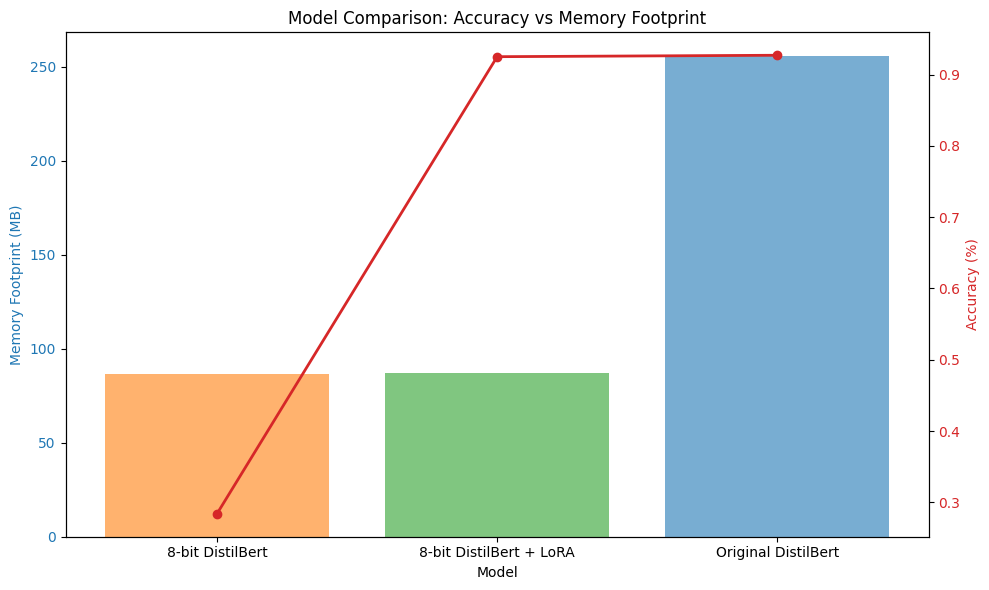

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["8-bit DistilBert", "8-bit DistilBert + LoRA", "Original DistilBert"]
accuracy = [accuracy_8bit, accuracy_8bit_lora, original_accuracy]
memory_footprint = [memory_8bit, memory_8bit_lora, original_memory]

# Define colors for each model
bar_colors = ['tab:orange', 'tab:green', 'tab:blue']

# Create the plot with different colors for each model
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for memory footprint with different colors for each model
ax1.set_xlabel('Model')
ax1.set_ylabel('Memory Footprint (MB)', color='tab:blue')
ax1.bar(models, memory_footprint, color=bar_colors, alpha=0.6, label='Memory Footprint (MB)')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary axis for accuracy
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:red')  
ax2.plot(models, accuracy, color='tab:red', marker='o', linewidth=2, label='Accuracy (%)')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and layout
plt.title('Model Comparison: Accuracy vs Memory Footprint')
fig.tight_layout()

# Show plot
plt.show()